In [1]:
%load_ext autoreload
%autoreload

In [2]:
import torch
import numpy as np
import polars as pl
from model_vae import *
from data_preparation import *
from plotting import create_latent_space_visualizations
from postprocess import process_and_visualize_relative_vectors

## Data Prep

In [4]:
# base_data_pl = pl.read_parquet("../cvrs/data/pass2/state=COLORADO/county_name=ADAMS/", columns = ["state", "county_name", "cvr_id", "candidate", "district", "magnitude", "office", "party_detailed"])

base = pl.scan_parquet("../cvrs/data/pass2/state=COLORADO").with_columns((pl.col('office') + '_' + pl.col('district')).alias('race'))

# data_subset = pl.read_parquet("adams_subset.parquet", columns = ["cvr_id", "office", "district", "candidate"])

# drop uncontested elections
small_candidates = (base
    .filter(pl.col("candidate") != "UNDERVOTE")
    .group_by(['race', 'candidate'])
    .agg(pl.len().alias('n'))
    .filter(pl.col('n') <= 20)
    .select(['race', 'candidate'])
    .unique())

# Equivalent of anti_join and subsequent operations
contested_races = (base
    .filter(pl.col("candidate") != "UNDERVOTE")
    # Anti-join equivalent: keep only rows where (race, candidate) is not in small_candidates
    .join(small_candidates, on=['race', 'candidate'], how='anti')
    .select(['race', 'candidate'])
    .unique()
    .group_by('race')
    .agg(pl.len().alias('n'))
    .filter(pl.col('n') > 1)
    .select('race'))

# Rejoin with original data to get all records for these individuals
final_data = (
    base
    .join(
        contested_races,
        on=['race'],
        how="inner"
    )
    # .join(
    #     sampled_data.select(["cvr_id"]),
    #     on=["cvr_id"],
    #     how="inner"
    # )
    .select(
        ["county_name", "cvr_id", "office", "district", "candidate"]
     )
    .filter(
        pl.col("candidate") != "UNDERVOTE"
    )
    .collect()
    .to_pandas()
)

final_data

county_name,cvr_id,office,district,candidate
str,i32,str,str,str
"""ADAMS""",1,"""US PRESIDENT""","""FEDERAL""","""JOSEPH R BIDEN"""
"""ADAMS""",1,"""US SENATE""","""COLORADO""","""JOHN W HICKENLOOPER"""
"""ADAMS""",1,"""US HOUSE""","""007""","""ED PERLMUTTER"""
"""ADAMS""",1,"""STATE BOARD OF EDUCATION""","""7""","""KARLA ESSER"""
"""ADAMS""",1,"""UNIVERSITY REGENT""","""UNIVERSITY OF COLORADO 7""","""NOLBERT CHAVEZ"""
…,…,…,…,…
"""YUMA""",5029,"""PROPOSITION""","""114""","""NO"""
"""YUMA""",5029,"""PROPOSITION""","""115""","""YES"""
"""YUMA""",5029,"""PROPOSITION""","""116""","""NO"""


## Model Setup

In [17]:
# Prepare data for the VAE model
print("\nPreparing data for VAE model...")
input_data, target_indices, participation_mask_tensor, num_candidates_per_contest, metadata = load_and_prepare_voter_data(final_data)

# Create and train the model
# Model parameters
hidden_dim = 64
latent_dim = 2
num_epochs = 3
batch_size = 64
learning_rate = 1e-3
kl_weight = 0.1

pres_race_name = "US PRESIDENT_FEDERAL"
trump_name = "DONALD J TRUMP"
biden_name = "JOSEPH R BIDEN"

model = VoterChoiceVAE(
    num_contests=len(num_candidates_per_contest),
    num_candidates_per_contest=num_candidates_per_contest,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim
)
model = model.to(get_device())



Preparing data for VAE model...
Prepared data from 398474 voters across 662 contests
Number of candidates per contest: [2, 6, 4, 5, 3, 4, 3, 4, 7, 5, 7, 6, 6, 3, 4, 1, 1, 6, 12, 5, 5, 6, 6, 3, 2, 3, 1, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 1, 2, 2, 3, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 1, 1, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 4, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 3, 1, 1, 1, 1, 2, 3, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 6, 4, 2, 3, 2, 2, 5, 5, 2,

In [18]:
# Train with constraint
soft_model = train_voter_vae_constrained(
    model, 
    input_data, 
    target_indices,
    participation_mask_tensor,
    metadata, 
    pres_race_name, 
    trump_name, 
    biden_name,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    kl_weight=kl_weight,
    constraint_weight=5.0  # Adjust as needed
)

# Apply post-processing to ensure consistent orientation of all latent dimensions
soft_model = post_process_latent_space(soft_model, metadata, pres_race_name, trump_name, biden_name)

Applying constraint: DONALD J TRUMP (idx 11) > JOSEPH R BIDEN (idx 20)


KeyboardInterrupt: 

In [ ]:
# Save only the model parameters
torch.save(soft_model.state_dict(), 'models/voter_choice_vae_state_dict.pt')

In [5]:
# Generate and analyze embeddings
print("\nGenerating voter embeddings...")
voter_embeddings_df = analyze_voter_embeddings(soft_model, input_data, participation_mask_tensor, metadata)

# Display embeddings sample
print("\nSample of voter embeddings:")
print(voter_embeddings_df.head())

# Extract IRT parameters
print("\nExtracting IRT-equivalent parameters...")
discrimination_params, difficulty_params = soft_model.get_irt_parameters()

# Convert to more interpretable format
print("\nSample of discrimination parameters for the first contest:")
first_contest = list(metadata['race_to_idx'].keys())[5]
first_contest_idx = metadata['race_to_idx'][first_contest]
first_contest_discrimination = discrimination_params[first_contest_idx].numpy()

print(f"Contest: {first_contest}")
for i, candidate in enumerate(metadata['candidate_maps'][first_contest_idx].keys()):
    print(f"  Candidate: {candidate}")
    print(f"    Discrimination parameters: {first_contest_discrimination[i]}")


Generating voter embeddings...

Sample of voter embeddings:
    trait_0 voter_id
0  0.014055   100006
1  0.037303   100010
2  0.019224   100037
3  0.038599   100135
4  0.034058   100204

Extracting IRT-equivalent parameters...

Sample of discrimination parameters for the first contest:
Contest: COURT OF APPEALS_COLORADO - TOW
  Candidate: NO
    Discrimination parameters: [0.00763756]
  Candidate: YES
    Discrimination parameters: [0.02439648]


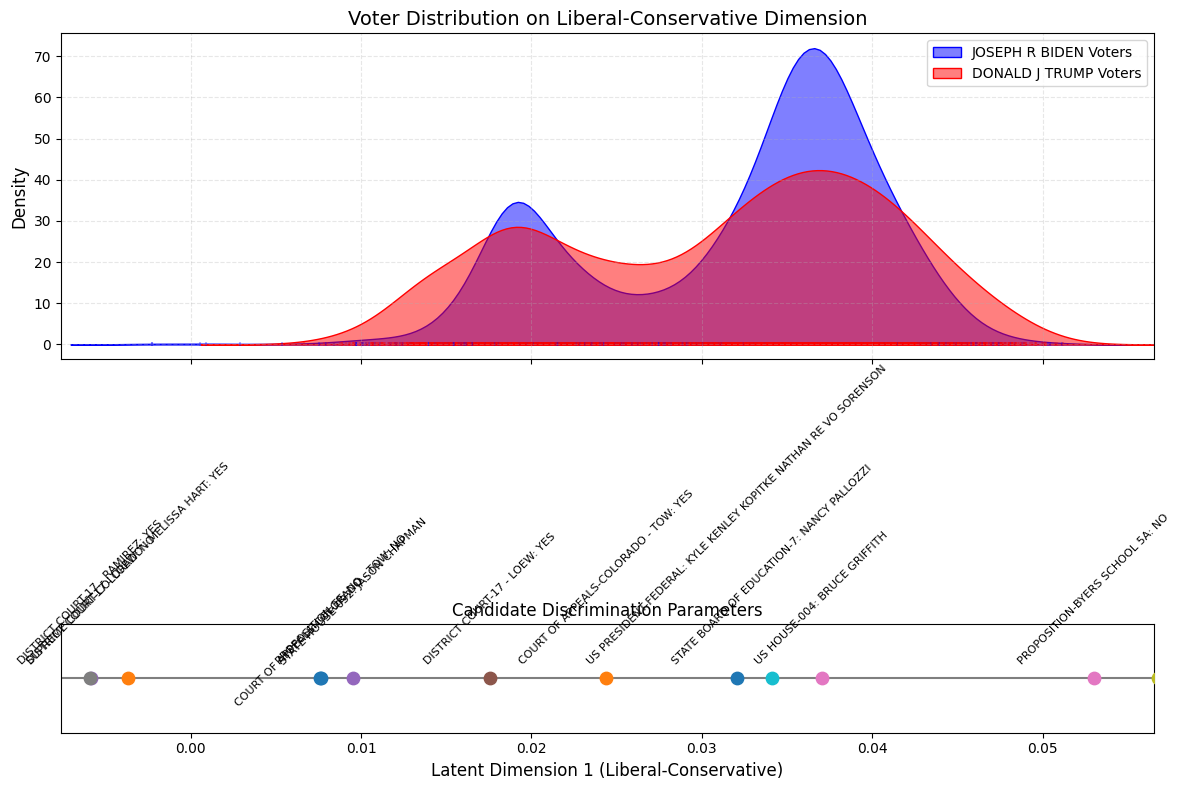

In [6]:
office_idx = metadata["race_to_idx"]["US PRESIDENT_FEDERAL"]
biden_idx = metadata["candidate_maps"][office_idx]["JOSEPH R BIDEN"]

# Now apply reference candidate post-processing for visualization
adjusted_params, reference_info = process_and_visualize_relative_vectors(
    soft_model, input_data, participation_mask_tensor, metadata, final_data, reference_candidates = {office_idx: biden_idx},
    contest_filter = ["PROPOSITION"]
)

In [12]:
metadata["candidate_maps"]

[{'ALEXANDER SKINNY WINKLER': 0, 'EVA HENRY': 1},
 {'CHARLES CHAZ TEDESCO': 0, 'JAMES K TREIBERT': 1},
 {'LYNN BACA': 0, 'PHIL COVARRUBIAS': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'BRIAN MASON': 0, 'TIM MC CORMACK': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'NO': 0, 'YES': 1},
 {'KARLA ESSER': 0, 'NANCY PALLOZZI': 1},
 {'DAFNA MICHAELSON JENET': 0, 'KERRIE GUTIERREZ': 1},
 {'YADIRA CARAVEO': 0},
 {'ADRIENNE BENAVIDEZ': 0, 'JASO

In [11]:
adjusted_params[-2]

tensor([[-0.0660],
        [-0.0619],
        [-0.1236],
        [-0.0601],
        [-0.1187],
        [ 0.0187],
        [-0.0598],
        [-0.1037],
        [-0.1121],
        [ 0.0000],
        [ 0.0947],
        [ 0.0321],
        [ 0.1264],
        [ 0.1167],
        [ 0.0793],
        [ 0.1207]])

## Archive

In [20]:
create_latent_space_visualizations(
    soft_model, input_data, participation_mask_tensor, metadata,
    final_data, num_candidates_per_contest, pres_race_name, trump_name, biden_name
)

Creating latent space visualizations...


KeyError: 'trait_1'

<Figure size 1000x800 with 0 Axes>